# Chapter 9 - Decision Analysis

- Price is Right: contestants are shown a collection of items, and have to guess the price. The person who is closest, without going over, is the winner and gets all of the stuff.

Two people are shown the collection, and need to pick their price.

Questions:
1. Before seeing the collection, what prior beliefs should the contestants have about the prizes?
2. After seeing the collection, how should they update their beliefs?
3. Based on the posterior distibution, how should the contestants bid?

To choose a prior distribution, let's look at the data. The data has been compiled, and is of the 2011 and 2012 seasons

In [1]:
import pandas as pd

def read_data(filename):
    """ Read the showcase data file """
    df = pd.read_csv(filename, index_col=0, skiprows=[1])
    return df.dropna().transpose()

df2011 = read_data('./data/showcases.2011.csv')
df2012 = read_data('./data/showcases.2012.csv')
df = pd.concat([df2011, df2012], ignore_index=True)

df.head()

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
0,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
1,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
2,32815.0,53186.0,32000.0,45000.0,815.0,8186.0
3,44432.0,31428.0,27000.0,38000.0,17432.0,-6572.0
4,24273.0,22320.0,18750.0,23000.0,5523.0,-680.0


The first two columns are the actual prices; the Bid columns are the bids. Difference are actual - bid.

## Kernel Density Estimation

This dataset contains the information for 313 showcases, which we can think of as being a sample from the population of possible prices.

To generate our guess as to the prior distribution, we can use [Kernel Density Estimation (KDE)](https://mathisonian.github.io/kde/)

SciPY includes a `gaussian_kde` function, which takes in some data and returns the estimated distribution.

<AxesSubplot:>

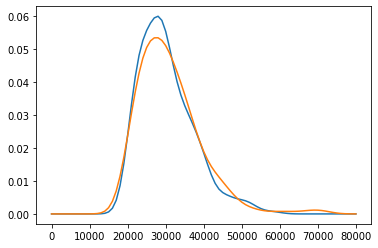

In [2]:
from scipy.stats import gaussian_kde
from empiricaldist import Pmf
import numpy as np

def kde_from_sample(sample, qs):
    """ Make the kernel density estimation from a sample """
    kde = gaussian_kde(sample)
    ps = kde(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

qs = np.linspace(0, 80000, 81)
prior1 = kde_from_sample(df['Showcase 1'], qs)
prior1.plot()
prior2 = kde_from_sample(df['Showcase 2'], qs)
prior2.plot()

## Distribution of Error

To update the priors, we have to consider the questions:
1. What data should we consider and how should we quantify it?
2. Can we compute a likelihood function? That is, for each hypothetical price, can we compute the conditional likelihood of the data?

To answer these questions, we can model each contestant as a guessing machine with some sort of error characteristic. 

The question that we have to answer is, "If the actual price is `price`, what is the likelihood that the contestant's guess would be `guess`?

Equivalently, if we define `error = guess - price`, what is the probability that the contestant will be off by `error`?

Let's use historical data again! We can create a sample distribution from the supplied data:

<AxesSubplot:>

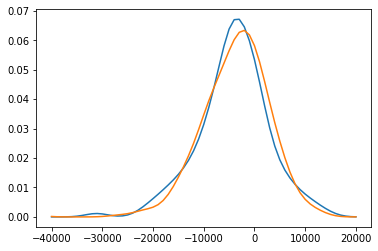

In [3]:
sample_diff1 = df['Bid 1'] - df['Showcase 1']
sample_diff2 = df['Bid 2'] - df['Showcase 2']

qs = np.linspace(-40000, 20000, 61)
kde_diff1 = kde_from_sample(sample_diff1, qs)
kde_diff2 = kde_from_sample(sample_diff2, qs)
kde_diff1.plot()
kde_diff2.plot()

These both look roughly normal, so we can characterize them by their mean and standard deviation.

In [4]:
mean_diff1 = sample_diff1.mean()
std_diff1 = sample_diff1.std()
mean_diff2 = sample_diff2.mean()
std_diff2 = sample_diff2.std()

Now we want to model their guesses as to the value. Tragically though, we don't know their best estimate of the value; all we have is their bid! Let's make some assumptions here:

1. They are actually able to guess the value, they are just deliberately under bidding because under the rules, they automatically lose if they go over. Thus, their 'true mean' is 0
2. The standard deviation actually reflects the real standard deviation

In [5]:
from scipy.stats import norm

error_dist1 = norm(0, std_diff1)
error_dist2 = norm(0, std_diff2)

## Update

Say you are player 1. You estimate that the prizes in your collection are worth $23,000.

From the guess, let's subtract away all of the guesses in the prior. The result will be the errors under each hypothesis.

In [6]:
guess1 = 23000
error1 = guess1 - prior1.qs

If we assume that our error is well-modelled by `error_dist`:

<AxesSubplot:>

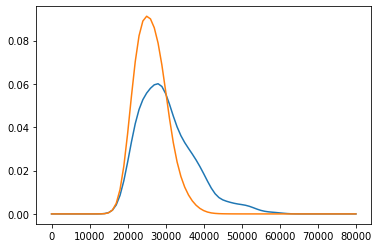

In [7]:
likelihood1 = error_dist1.pdf(error1)
posterior1 = prior1 * likelihood1
posterior1.normalize()
prior1.plot()
posterior1.plot()
## Orange (taller one) is the posterior

In [8]:
print(f"Means: {prior1.mean()} -> {posterior1.mean()}")

Means: 30299.488817891375 -> 26192.024002392536


So: before you saw the prize, you expected it to be worth $\$30,000$. After seeing it and estimating the value at $\$23,000$, you now believe it to be about $\$26000$. You have an understanding of your own error.

### Exercise 9-2
> Now do the same for player 2, assuming that their estimate is $\$38,000$

<AxesSubplot:>

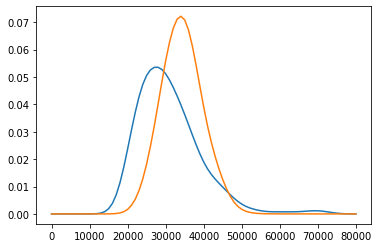

In [9]:
guess2 = 38000
error2 = guess2 - prior2.qs
likelihood2 = error_dist2.pdf(error2)
posterior2 = prior2 * likelihood2
posterior2.normalize()
prior2.plot()
posterior2.plot()

In [10]:
posterior2.mean()

34305.20161642468

## Probability of Winning

Now that we have a posterior distribution for the contestants: strategy!

Let's be player 1. Let's compute the probability that Player 2 overbids:

In [11]:
def prob_overbid(sample_diff):
    """ Compute the probability of an overbid """
    return np.mean(sample_diff > 0)
prob_overbid(sample_diff2)

0.29073482428115016

Now suppose that player 1 underbids by 5000. What is the probability that player 2 underbids by more?

In [12]:
def prob_worse_than(diff, sample_diff):
    """ The probability that the opponent diff is worse than the given difference amount """
    return np.mean(sample_diff < diff)
prob_worse_than(-5000, sample_diff2)

0.38338658146964855

In [13]:
prob_worse_than(-10000, sample_diff2)

0.14376996805111822

Let's combine these to compute the probability that Player 1 wins, given the difference between their bid and the actual price:

In [14]:
def compute_prob_win(diff, sample_diff):
    """ Probability of winning, for a given difference """
    # If you overbid, you lose
    if diff > 0:
        return 0
    
    # if the oppnent overbids (but you don't), you win
    p1 = prob_overbid(sample_diff)
    
    # if their bid is worse that yours, you win
    p2 = prob_worse_than(diff, sample_diff)
    
    # since they are mutually exclusive, it is fine to add them
    return p1 + p2

# Probability that you win, given that you underbid by 5000:
compute_prob_win(-5000, sample_diff2)

0.6741214057507987

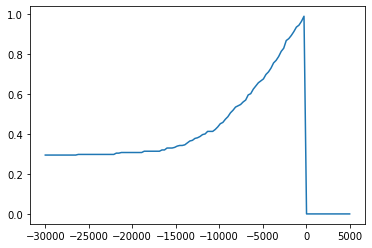

In [15]:
import matplotlib.pyplot as plt

# for a wide variety of possible differences:
xs = np.linspace(-30000, 5000, 121)
ys = [ compute_prob_win(diff, sample_diff2) for diff in xs ]
fig, ax = plt.subplots()
ax.plot(xs, ys)

### Excercise 9-3
> Run the same analysis from Player 2's perspective
> 1. Calculate the probability that Player 1 overbids
> 1. Calculate the probability that Player 1 underbids by more than 5000
> 1. The probability that Player 2 wins, given that Player 2 underbids by 5000

Probability that Player 2 wins: 0.6453674121405751


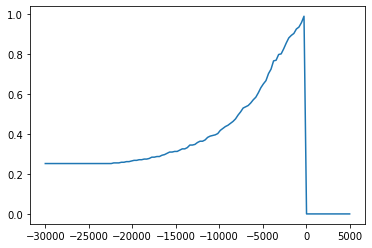

In [16]:
xs = np.linspace(-30000, 5000, 121)
ys = [ compute_prob_win(diff, sample_diff1 ) for diff in xs ]
fix, ax = plt.subplots()
ax.plot(xs, ys)
print(f"Probability that Player 2 wins: {compute_prob_win(-5000, sample_diff1)}")

## Decision Analysis

So if we know how much we've underbid by, then we can calculate some probabilities. Problem: we don't know that! But we have a distribution of the price, which should help us. So:

Function to calculate the probability of winning, given a possible bid, a posterior distribution of the actual amount, and the distribution of the opponent's errors.

It loops through the prices in the posterior, and, for each price:
1. Computes the difference between the bid and the hypothetical price
2. Computes the probability that the player wins, given that difference
3. Adds up the weighted sum of the probabilityies, where the weghts are the probabilities in the posterior distribution

In [17]:
def total_prob_win(bid, posterior, sample_diff):
    """ 
    Computes the total probability of winning the game
    
    Arguments:
        bid: your bid amount
        posterior: the posterior distribution of the actual prize amount
        sample_diff: sequence of differences for the opponent
    
    Returns:
        The probability of winning
    """
    total = 0
    for price, prob in posterior.items():
        diff = bid - price
        total += prob * compute_prob_win(diff, sample_diff)
    return total

(This is the law of total probability)
$$
P(win) = \sum_{\text{price}}P(\text{price})P(\text{win}|\text{price})
$$

In [18]:
total_prob_win(25000, posterior1, sample_diff2)

0.4842210945439812

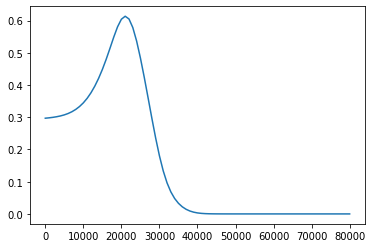

In [19]:
# We can loop through a bunch of different bids to calculate the probabilities
bids = posterior1.qs
probs = [ total_prob_win(bid, posterior1, sample_diff2) for bid in bids ]
fig, ax = plt.subplots()
ax.plot(bids, probs)

In [20]:
prob_win_series = pd.Series(probs, index=bids)
print(prob_win_series.idxmax(), prob_win_series.max())

21000.0 0.6136807192359474


### Exercise 9-5 
> Do the same analysis for Player 2

29000.0 0.5171370053364229


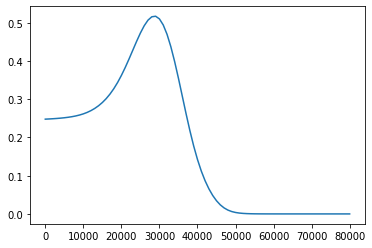

In [21]:
bids = posterior2.qs
probs = [ total_prob_win(bid, posterior2, sample_diff1) for bid in bids ]
fix, ax = plt.subplots()
ax.plot(bids, probs)

prob_win_series = pd.Series(probs, index=bids)
print(prob_win_series.idxmax(), prob_win_series.max())

## Maximizing Expected Gain

The solution so far is correct, *but* it just maximimzes the chance of winning, not the expected payoff. Remember that if you are off by less than $\$$250, you win *both* prizes.

In [22]:
def compute_gain(bid, price, sample_diff):
    """ Compute the expected gain, given a bid and actual price """
    diff = bid - price
    prob = compute_prob_win(diff, sample_diff)
    
    # If you are within 250 dollars, you win both showcases
    if -250 <= diff <= 0:
        return 2 * price * prob
    else:
        return price * prob

If the actual price is 35,000 and you bid 30,000, you will win about $\$$ 23,600 worth of prizes, taking into account your probability of losing, winning one showcase, or winning both.

In [23]:
compute_gain(30000, 35000, sample_diff2)

23594.249201277955

Of course, we don't have the actual price; instead, we have a posterior distribution of the price! By averaging over the price and the probability of it actually being that price, we can compute the expected gain for a bid.

In this case, 'expected' means the average over the possible showcase values, weighted by their probabilities.

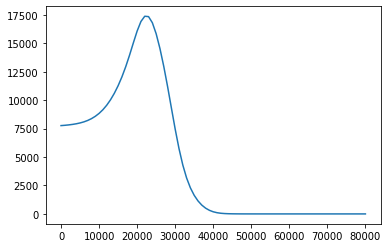

In [24]:
def expected_gain(bid, posterior, sample_diff):
    """ Compute the expected gain of a given bid """
    total = 0
    for price, prob in posterior.items():
        total += prob * compute_gain(bid, price, sample_diff)
    return total

# While we're at it, we should now loop through the possible values of the bid 
# and see which one gives us the best expected value!
bids = posterior1.qs
gains = [ expected_gain(bid, posterior1, sample_diff2) for bid in bids ]
fix, ax = plt.subplots()
ax.plot(bids, gains)

In [25]:
as_series = pd.Series(gains, index=bids)
print(as_series.idxmax(), as_series.max())

22000.0 17384.899584430797


So actually, we should slightly increase the amount of our bid to increase the chance of us getting into that magical <250 off zone.

### Exercise 9-5
> Do the same for player 2

30000.0 19404.164188501607


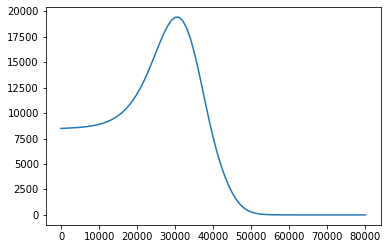

In [26]:
bids = posterior2.qs
gains = [expected_gain(bid, posterior2, sample_diff1) for bid in bids ]
fix, ax = plt.subplots()
ax.plot(bids, gains)

as_series = pd.Series(gains, index=bids)
print(as_series.idxmax(), as_series.max())

So again, we see a slight increase.

### Exercise 9.????

- How many books to order?
- Assume that it is a Poisson process
- Cost of ordering books is \$ 5 per
    - Unless you order more than >=100; then it is \$4.5 per
- For every book you sell, you get \$10
- If you run out of books before 8 weeks, you lose \$50 in future sales for each week that you are out
- If you have books left over at the end of 8 weeks, you lose \$2 / book in inventory costs

- E.g. Say you sell exactly 10 books per week. If you order 60 books, then
    - Total cost is \$300
    - You sell all 60 books, so you make \$600
    - You are out of stock for 2 weeks, so you lost \$100
    - -> total profit is -300 + 600 - 100 = 200
    
- Combining these costs with the prior predictive distribution, how many books should you order to maximize your expected profit?

In [27]:
from typing import List

def print_cost(printed: int) -> float:
    """ Calculate the cost of printing printed number of books """
    return printed * 5 if printed < 100 else printed * 4.5

def total_income(printed: int, orders: List[int]) -> float:
    """ Given the number printed and a list representing the orders by week, calculate the total income """
    return 10 * min(printed, sum(orders))

def inventory_cost(printed: int, orders: List[int]) -> float:
    """ Given the number printed and a list representing the orders by week, calculate the inventory costs """
    return 2 * max(printed - sum(orders), 0)
    
def out_of_stock_cost(printed: int, orders: List[int]) -> float:
    weeks = len(orders)
    total_orders = np.cumsum(orders)
    for i, total in enumerate(total_orders):
        if total > printed:
            return (weeks - i) * 50
    return 0

def compute_profit(printed, orders):
    return total_income(printed, orders) - print_cost(printed) - out_of_stock_cost(printed, orders) - inventory_cost(printed, orders)

for printed in [60, 100]:
    print(compute_profit(printed, [10] * 8))
assert compute_profit(60, [10] * 8) == 200
assert compute_profit(100, [10] * 8) == 310

200
310.0


Start with the arbitrary assumption that the number of books ordered in a week comes from a Gamma distribution with mean 9.

8.998788382371902

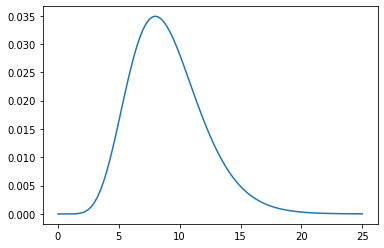

In [28]:
from scipy.stats import gamma

alpha = 9
qs = np.linspace(0, 25, 101)
ps = gamma(alpha).pdf(qs)
pmf = Pmf(ps, qs)
pmf.normalize()
pmf.plot()
pmf.mean()

So this is our prior distribution for the number of books ordered in a given week. Kind of - it's actually the distribution of $\lambda$ for our Poisson distribution.

Now that we have that, we can run a simulation - draw 1000 samples from this distribution, and calculate the likely profit from each.

In [29]:
rates = pmf.choice(1000)
np.mean(rates)

9.00075

In [30]:
np.random.seed(17)
orders_array = np.random.poisson(rates, size=(8, 1000)).transpose()
orders_array[:5, :]

array([[ 5,  6,  9,  8, 13,  7,  8,  9],
       [ 5, 11, 15, 10,  4,  4,  9,  8],
       [10, 14, 11, 12, 10, 12,  5,  8],
       [ 5,  6,  9,  7,  6,  5,  7, 11],
       [ 9, 14,  6,  9, 15, 13, 13, 12]])

In [31]:
def compute_expected_profits(printed, order_array):
    profits = [ compute_profit(printed, orders) for orders in order_array ]
    return np.mean(profits)

for printed in [70, 80, 90]:
    print(compute_expected_profits(printed, orders_array))

184.288
184.652
162.322


<AxesSubplot:>

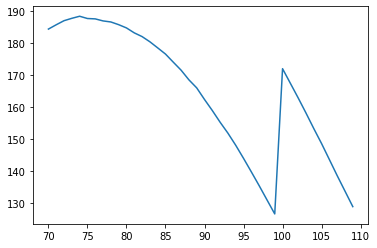

In [32]:
possible_book_printings = np.arange(70, 110)
profits = [ compute_expected_profits(printed, orders_array) for printed in possible_book_printings ]
expected_profits = pd.Series(profits, possible_book_printings)
expected_profits.plot()

In [33]:
expected_profits.idxmax(), expected_profits.max()

(74, 188.296)

Now let's choose some sort of reasonable prior, and update it with the data that we are given; then let's re-run the simulation

<AxesSubplot:>

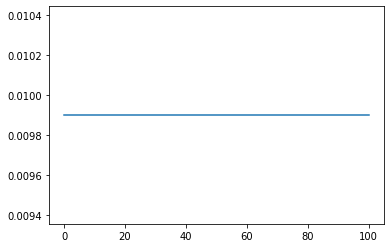

In [34]:
possible_lambdas = np.linspace(0, 100, 101)

# choose a uniform prior
uniform_prior = Pmf(1, possible_lambdas)
uniform_prior.normalize()
uniform_prior.plot()

In [35]:
from scipy.stats import poisson
def updated_with_poisson(pmf, data):
    """ Given a PMF that represents the probabilities for different lambda, update it with a measurement """
    copied = pmf.copy()
    lams = pmf.index
    likelihood = poisson.pmf(data, lams)
    copied *= likelihood
    copied.normalize()
    return copied

<AxesSubplot:>

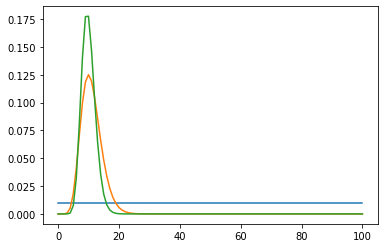

In [36]:
after_first = updated_with_poisson(uniform_prior, 10)
after_second = updated_with_poisson(after_first, 9)
uniform_prior.plot()
after_first.plot()
after_second.plot()

In [37]:
uniform_prior.mean(), after_first.mean(), after_second.mean()

(50.0, 11.000000029811321, 9.999999999186826)

9.921 1000
[[11 12 15 11 10 13  8 18]
 [10  8  8  6  9  8  6  6]
 [ 8  6  8  3 10  6  8  4]
 [ 8  9  7  9  4  3  3  9]
 [ 6 10 14 12 11 10  9 13]]


<AxesSubplot:>

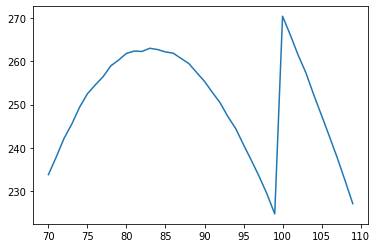

In [41]:
rates = after_second.choice(1000)
print(np.mean(rates), len(rates))
orders_array = np.random.poisson(rates, size=(8, 1000)).transpose()
print(orders_array[:5, :])

possible_book_printings = np.arange(70, 110)
profits = [ compute_expected_profits(printed, orders_array) for printed in possible_book_printings ]
expected_profits = pd.Series(profits, possible_book_printings)
expected_profits.plot()

In [42]:
expected_profits.idxmax(), expected_profits.max()

(100, 270.438)